#### Fardin Rastakhiz @2023

In [1]:
from Scripts.Configs.ConfigClass import Config
from Scripts.DataManager.GraphConstructor.GraphConstructor import TextGraphType
import os
from Scripts.DataManager.GraphLoader.AGGraphDataModule import AGGraphDataModule
import torch

config = Config(r'C:\Users\fardin\Projects\ColorIntelligence')
# config = Config(r'E:\Darsi\Payan Name Arshad\Second Work\ColorIntelligence2\ColorIntelligence')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 256

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\typing.py:90: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\typing.py:101: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
from Scripts.Models.GraphEmbedding.HeteroDeepGraphEmbedding4 import HeteroDeepGraphEmbedding4
from Scripts.Models.GraphEmbedding.HeteroDeepGraphEmbedding5 import HeteroDeepGraphEmbedding5
from Scripts.Models.GraphEmbedding.HeteroDeepGraphEmbedding6 import HeteroDeepGraphEmbedding6

In [3]:
from Scripts.Models.LightningModels.LightningModels import HeteroMultiClassLightningModel
from Scripts.Models.LossFunctions.HeteroLossFunctions import MulticlassHeteroLoss1, MulticlassHeteroLoss2
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
import lightning as L
from lightning.pytorch.tuner import Tuner
from Scripts.Models.ModelsManager.ClassifierModelManager import ClassifierModelManager

In [4]:
graph_type = TextGraphType.SENTIMENT
data_manager = AGGraphDataModule(config, True, True, test_size=0.05511811, val_size=0.05, shuffle=False, start_data_load=0 , end_data_load = 127000 , device='cpu', batch_size=batch_size, graph_type=graph_type, load_preprocessed_data = True)
data_manager.load_labels()
data_manager.load_graphs()

filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/AG\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 127/127 [16:12<00:00,  7.66s/it]


In [5]:
test_dataloader = data_manager.test_dataloader()
X3, Y3 = next(iter(test_dataloader))

In [6]:

edge_type_weights = [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.]

In [7]:
from os import path
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss
import torchmetrics

def save_evaluation(model, eval_dataloader, name_prepend: str='',
                 give_confusion_matrix: bool=True, 
                 give_report: bool=True, 
                 give_f1_score: bool=False, 
                 give_accuracy_score: bool=False, 
                 give_precision_score: bool=False, 
                 give_recall_score: bool=False, 
                 give_hinge_loss: bool=False,
                 multi_class: bool=False,
                 device='cuda'
                 ):
        
        test_metrics_path = path.join(r'logs\hetero_model_18_AG\version_26', f'{name_prepend}_test_metrics.txt')
        
        y_true = []
        y_pred = []
        model.eval()
        for X, y in eval_dataloader:
            model.eval()
            with torch.no_grad():
                y_p = model(X.to(device))
            if type(y_p) is tuple:
                y_p = y_p[0]
            
            if multi_class:
                y_pred.append(y_p.detach().to(y.device))
                y_true.append(y)
            else:
                y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
                y_true.append(y.to(torch.int32))
        y_true = torch.concat(y_true)
        y_pred = torch.concat(y_pred)
        print(y_true.shape)
        print(y_pred.shape)
        if multi_class:
            y_true_num = torch.argmax(y_true, dim=1)
            y_pred_num = torch.argmax(y_pred, dim=1)
        else:
            y_true_num = y_true
            y_pred_num = y_pred
            
        print(y_true_num.shape)
        print(y_pred_num.shape)
        with open(test_metrics_path, 'at+') as f:
            if(give_confusion_matrix):
                print(f'confusion_matrix: \n{confusion_matrix(y_true_num, y_pred_num)}', file=f)
            if(give_report):
                print(classification_report(y_true_num, y_pred_num), file=f)
            if(give_f1_score):
                if multi_class:
                    print(f'f1_score: {f1_score(y_true_num, y_pred_num, average=None)}', file=f)
                else:
                    print(f'f1_score: {f1_score(y_true_num, y_pred_num)}', file=f)
            if(give_accuracy_score):
                print(f'accuracy_score: {accuracy_score(y_true_num, y_pred_num)}', file=f)
            if(give_precision_score):
                if multi_class:
                    print(f'f1_score: {precision_score(y_true_num, y_pred_num, average=None)}', file=f)
                else:
                    print(f'f1_score: {precision_score(y_true_num, y_pred_num)}', file=f)
            if(give_recall_score):
                if multi_class:
                    print(f'f1_score: {recall_score(y_true_num, y_pred_num, average=None)}', file=f)
                else:
                    print(f'f1_score: {recall_score(y_true_num, y_pred_num)}', file=f)
            if(give_hinge_loss):
                print(f'hinge_loss: {hinge_loss(y_true_num, y_pred)}', file=f)


In [8]:
graph_embedding = HeteroDeepGraphEmbedding6(300, 4, X3.metadata(), 32, dropout=0.2, edge_type_count=11, edge_type_weights=[1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.])
lightning_model = HeteroMultiClassLightningModel.load_from_checkpoint(r'logs\hetero_model_18_AG\version_26\checkpoints\epoch=74-step=35100.ckpt', model=graph_embedding, num_classes=4)
lightning_model.eval()
lightning_model.model.edge_type_weights
lightning_model.model.pw1 
# lightning_model()

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\GraphEmbedding\HeteroDeepGraphEmbedding6.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.], device='cuda:0')

In [9]:
save_evaluation(lightning_model, data_manager.val_dataloader(), name_prepend='val2', multi_class=True)
save_evaluation(lightning_model, data_manager.test_dataloader(), name_prepend='test2', multi_class=True)

torch.Size([6350, 4])
torch.Size([6350, 4])
torch.Size([6350])
torch.Size([6350])
torch.Size([7000, 4])
torch.Size([7000, 4])
torch.Size([7000])
torch.Size([7000])


In [10]:
import torch_geometric
from torch_geometric.data import Batch
import numpy as np

In [11]:
correct_answers = []
y_preds = []
y_trues = []
x_s = []
x_dicts = []
for X,Y in data_manager.test_dataloader():
    y_pred, x_dict = lightning_model(X.to(device))
    corrects = torch.argmax(Y, dim=1) == torch.argmax(y_pred, dim=1).to('cpu')
    correct_answers.append(corrects)
    y_preds.append(y_pred.cpu())
    y_trues.append(Y)
    x_s.append(X)
    x_dicts.append(x_dict)

correct_answers = torch.concat(correct_answers)
y_preds = torch.concat(y_preds)
y_trues = torch.concat(y_trues)
# x_dicts = [li[i] for li in x_s for k in li.x_dict]
# x_s = [li[i] for li in x_s for i in range(len(li))]

In [12]:
def get_hidden_x_dict(t_model, x):
    t_model.x_batches = {k:x[k].batch for k in t_model.active_keys}
    # self.x_batches_cpu = {k:self.x_batches[k].to('cpu') for k in self.active_keys}
    x_dict, edge_attr_dict, edge_index_dict = t_model.preprocess_data(x)
    edge_attr_dict = t_model.update_weights(edge_attr_dict, t_model.pw1)
    x_dict = t_model.hetero_linear1(x_dict)
    x_dict = t_model.hetero_gat_1(x_dict, edge_index_dict, edge_attr_dict)
    # self.x_dict_cpu_1 = {k: x_dict[k].to('cpu') for k in x_dict}
    t_model.normalize(x_dict, t_model.x_batches)
    x_dict = t_model.hetero_gat_2(x_dict, edge_index_dict, edge_attr_dict)
    
    return x_dict

In [13]:
lightning_model.model.pw1

Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.], device='cuda:0')

In [14]:
x_dicts2 = []
for X,Y in data_manager.test_dataloader():
    x_dict = get_hidden_x_dict(lightning_model.model, X.to(device))
    x_dicts2.append(x_dict)

In [15]:
x_s[0]['word'].batch

tensor([  0,   0,   0,  ..., 255, 255, 255], device='cuda:0')

In [16]:
softmaxed_output = torch.max(torch.nn.functional.softmax(y_preds, dim=1), dim=1)

In [21]:
torch.mean(softmaxed_output[0][correct_answers.to(torch.int)])

tensor(0.9778, grad_fn=<MeanBackward0>)

In [22]:
torch.mean(softmaxed_output[0][(~correct_answers).to(torch.int)])

tensor(0.9878, grad_fn=<MeanBackward0>)

In [23]:
torch.where(~correct_answers)[0]

tensor([   1,    6,    7,   18,   21,   22,   34,   51,   77,   81,  108,  118,
         123,  137,  181,  205,  213,  216,  220,  246,  256,  260,  284,  293,
         303,  305,  310,  314,  315,  321,  335,  342,  343,  344,  346,  353,
         370,  377,  397,  406,  446,  451,  454,  457,  465,  475,  486,  498,
         526,  554,  563,  566,  572,  576,  580,  600,  641,  652,  657,  662,
         674,  675,  678,  698,  703,  705,  707,  717,  725,  733,  741,  742,
         745,  760,  770,  831,  833,  837,  853,  872,  875,  885,  890,  894,
         910,  925,  932,  940,  942,  949,  953,  965, 1002, 1015, 1029, 1040,
        1041, 1049, 1060, 1071, 1072, 1078, 1082, 1085, 1096, 1108, 1175, 1181,
        1195, 1202, 1249, 1250, 1256, 1267, 1271, 1278, 1290, 1294, 1305, 1315,
        1324, 1339, 1359, 1362, 1374, 1386, 1436, 1445, 1464, 1492, 1506, 1507,
        1525, 1570, 1601, 1611, 1615, 1666, 1687, 1689, 1702, 1708, 1710, 1740,
        1772, 1777, 1779, 1788, 1794, 17

In [24]:
# x_falses = {}
# false_indices = torch.where(~correct_answers)[0]
# for i in false_indices:
#     x_falses[i]= x_s[i].cpu()

In [31]:
import spacy
nlp = spacy.load('en_core_web_lg')
def convert_to_word(vectors):
    words = []
    print(len(vectors))
    for i in range(len(vectors)):
        print(f'{i}/{len(vectors)}')
        ms = nlp.vocab.vectors.most_similar(np.asarray([vectors[i]]), n=1)
        ws = [nlp.vocab.strings[w] for w in ms[0][0]]
        # print(ws)
        for w in ws:
            words.append(w)
        if (i+1)%20==0:
            break
    return str.join(' ', words)

In [32]:
for fk in x_falses:
    print(f'{fk}: {torch.argmax(y_preds[fk])+1}: {torch.argmax(y_trues[fk])+1}')

17: 4: 3
31: 4: 3
43: 3: 4
85: 4: 3
115: 2: 1
125: 1: 3
148: 3: 1
156: 4: 3
168: 3: 1
169: 3: 1
201: 4: 1
222: 4: 3
241: 1: 2
249: 3: 1
270: 2: 1
272: 4: 1


In [114]:
for fk in x_falses:
    sent1 = convert_to_word(x_falses[fk].x_dict['word'])
    print(f'{fk}: {y_preds[fk]}: {sent1}')

30
0/30
1/30
2/30
3/30
4/30
5/30
6/30
7/30
8/30
9/30
10/30
11/30
12/30
13/30
14/30
15/30
16/30
17/30
18/30
19/30
17: tensor([-1.1081, -5.6563,  1.1286,  3.2956], grad_fn=<SelectBackward0>): file - sharer win court case two file sharing company have be tell by a court that they be not
61
0/61
1/61
2/61
3/61
4/61
5/61
6/61
7/61
8/61
9/61
10/61
11/61
12/61
13/61
14/61
15/61
16/61
17/61
18/61
19/61
31: tensor([-3.2203, -2.4525,  0.9664,  3.0983], grad_fn=<SelectBackward0>): Kazaa owner take heart from US copyright rule Sharman Networks , parent company of the peer - to - peer
42
0/42
1/42
2/42
3/42
4/42
5/42
6/42
7/42
8/42
9/42
10/42
11/42
12/42
13/42
14/42
15/42
16/42
17/42
18/42
19/42
43: tensor([-1.6281, -3.7225,  2.9117,  0.7627], grad_fn=<SelectBackward0>): Google Stock 's Wacky Debut after a false start that make the search giant 's stock appear to soar ,
50
0/50
1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
85: tensor([-2.92

In [128]:
len(x_dicts)

2

In [101]:
x_falses[0].x_dict['word']

tensor([[ 1.3654, -2.4475,  0.4772,  ..., -4.9878,  2.6154,  0.8769],
        [-5.2115,  3.5090, -1.2917,  ...,  1.1714,  1.7961, -5.0412],
        [-1.5135, -3.4081, -4.4678,  ..., -0.6146, -2.8728, -0.0831],
        ...,
        [-0.9795, -0.7505, -2.0660,  ..., -2.5537, -0.0830,  2.4934],
        [ 2.0427, -2.0691, -1.5910,  ..., -3.8809, -5.2335,  3.8502],
        [-0.0765, -4.6896, -4.0431,  ...,  1.3040, -0.5270, -1.3622]],
       device='cuda:0')

In [38]:
graph_embedding = HeteroDeepGraphEmbedding6(300, 4, X3.metadata(), 32, dropout=0.2, edge_type_count=11, edge_type_weights=edge_type_weights[0])
graph_embedding = graph_embedding.to(device)
lightning_model = HeteroMultiClassLightningModel.load_from_checkpoint(r'logs\hetero_model_18_AG\version_26\checkpoints\epoch=74-step=35100.ckpt', model=graph_embedding, num_classes=4)
lightning_model.eval()

c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\GraphEmbedding\HeteroDeepGraphEmbedding6.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


HeteroMultiClassLightningModel(
  (model): HeteroDeepGraphEmbedding6(
    (part_weight_norm): LayerNorm((11,), eps=1e-05, elementwise_affine=True)
    (norm): PairNorm()
    (drop): Dropout(p=0.2, inplace=False)
    (hetero_linear1): GraphModule(
      (linear): ModuleDict(
        (dep): Linear(in_features=300, out_features=32, bias=True)
        (tag): Linear(in_features=300, out_features=32, bias=True)
        (word): Linear(in_features=300, out_features=32, bias=True)
        (sentence): Linear(in_features=300, out_features=32, bias=True)
        (general): Linear(in_features=300, out_features=32, bias=True)
        (sentiment): Linear(in_features=300, out_features=32, bias=True)
      )
      (batch_norm): ModuleDict(
        (dep): BatchNorm(32)
        (tag): BatchNorm(32)
        (word): BatchNorm(32)
        (sentence): BatchNorm(32)
        (general): BatchNorm(32)
        (sentiment): BatchNorm(32)
      )
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (hetero_gat_

In [25]:
x_s2 = [li[i] for li in x_s for i in range(len(li))]

In [28]:
x_out_dicts = {}
x_in_dicts = {}
x_out2_dicts = {}
x_batches = {}
for i in range(len(x_dicts)):
    for k in ['word']: #x_s[i].x_dict
        for j, b in enumerate(x_s[i][k].batch):
            x_out_dicts[b] = x_dicts[i][k][j]
            x_out2_dicts[b] = x_dicts2[i][k][j]
            x_in_dicts[b] = x_s[i].x_dict[k][j]
        x_batches[b] = x_s[i][k].batch
x_out = list(x_out_dicts.values())
x_out2 = list(x_out2_dicts.values())
x_in = list(x_in_dicts.values())
x_out = [x_out[i][None, :] for i in range(len(x_out))]
x_out2 = [x_out2[i][None, :] for i in range(len(x_out2))]
x_in = [x_in[i][None, :] for i in range(len(x_in))]
x_out = torch.concat(x_out, dim=0)
x_out2 = torch.concat(x_out2, dim=0)
x_in = torch.concat(x_in, dim=0)

In [29]:
x_batches = []
for i in range(len(x_dicts)):
    for k in ['word']: #x_s[i].x_dict
        x_batches.append(x_s[i][k].batch + i*256.)
x_batches = torch.concat(x_batches)

In [30]:
torch.max(x_batches)

tensor(6999., device='cuda:0')

In [31]:
x_out2.shape

torch.Size([307497, 32])

In [32]:
from sklearn.manifold import TSNE

In [33]:
tsne_model = TSNE(2, perplexity=50, n_iter=5000)

In [34]:
out_result = tsne_model.fit_transform(x_out.detach().cpu())

In [ ]:
out2_result = tsne_model.fit_transform(x_out2.detach().cpu())

In [ ]:
in_result = tsne_model.fit_transform(x_in.detach().cpu())

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# y_preds = torch.concat(y_preds)
# y_trues = torch.concat(y_trues)
# y_trues[x_batches.cpu().to(torch.long)]

In [ ]:
def draw_result_tsne(labels, data, title):
    
    tsne_result_df = pd.DataFrame({'tsne_1': data[:,0], 'tsne_2': data[:,1], 'label': labels})
    # colors = {0: (1, 1, 0, 0.3), 1: (1, 0, 1, 0.3), 2:(0, 1, 1, 0.3), 3:(1, 0, 0, 0.3)}
    tsne_result_df = tsne_result_df.groupby('label')
   
    plt.figure(figsize=(9,9))
    
    for name, group in tsne_result_df:
        plt.plot(group['tsne_1'], group['tsne_2'], marker='o', linestyle='', markersize=3, alpha=0.5, label=name+1)
    lim = (data.min()-5, data.max()+5)
    plt.xlim(lim)
    plt.ylim(lim)
    plt.gca().set_aspect('equal')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, fontsize="16")
    plt.axis('off')
    plt.show()

In [ ]:
def draw_all_results_tsne(title):
    y_labels = ['predictions', 'trues']
    x_labels = ['input data', 'not transformed output data', 'transformed output data']
    
    fig, ax = plt.subplots(2, 3, figsize=(19, 12))
    for i, y in enumerate([y_preds, y_trues]):
        for j, x in enumerate([in_result, out2_result, out_result]):
            
            tsne_result_df = pd.DataFrame({'tsne_1': x[:,0], 'tsne_2': x[:,1], 'label': torch.argmax(y[x_batches.cpu().to(torch.long)], dim=1)})
            # colors = {0: (1, 1, 0, 0.3), 1: (1, 0, 1, 0.3), 2:(0, 1, 1, 0.3), 3:(1, 0, 0, 0.3)}
            tsne_result_df = tsne_result_df.groupby('label')
                        
            for name, group in tsne_result_df:
                ax[i, j].plot(group['tsne_1'], group['tsne_2'], marker='o', linestyle='', markersize=3, alpha=0.5, label=name+1)
            lim = (x.min()-5, x.max()+5)
            ax[i, j].set_xlim(lim)
            ax[i, j].set_ylim(lim)
            ax[i, j].set_aspect('equal')
            ax[i, j].tick_params(bottom=False, top=False, right=False, left=False, labelbottom=False, labelleft=False)         
            if i == 0 and j == len(x_labels)-1:
                ax[i,j].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, fontsize="20", markerscale=2)
            
            if i == len(y_labels) - 1:
                ax[i, j].set_xlabel(f'{x_labels[j]}', fontsize="20")
                ax[i, j].xaxis.set_label_position('bottom')
            
            if j == 0:
                ax[i, j].set_ylabel(y_labels[i], fontsize="20")
                ax[i, j].yaxis.set_label_position('left')
                
    # plt.title(title)
    # plt.axis('off')
    plt.tight_layout()
    plt.show()

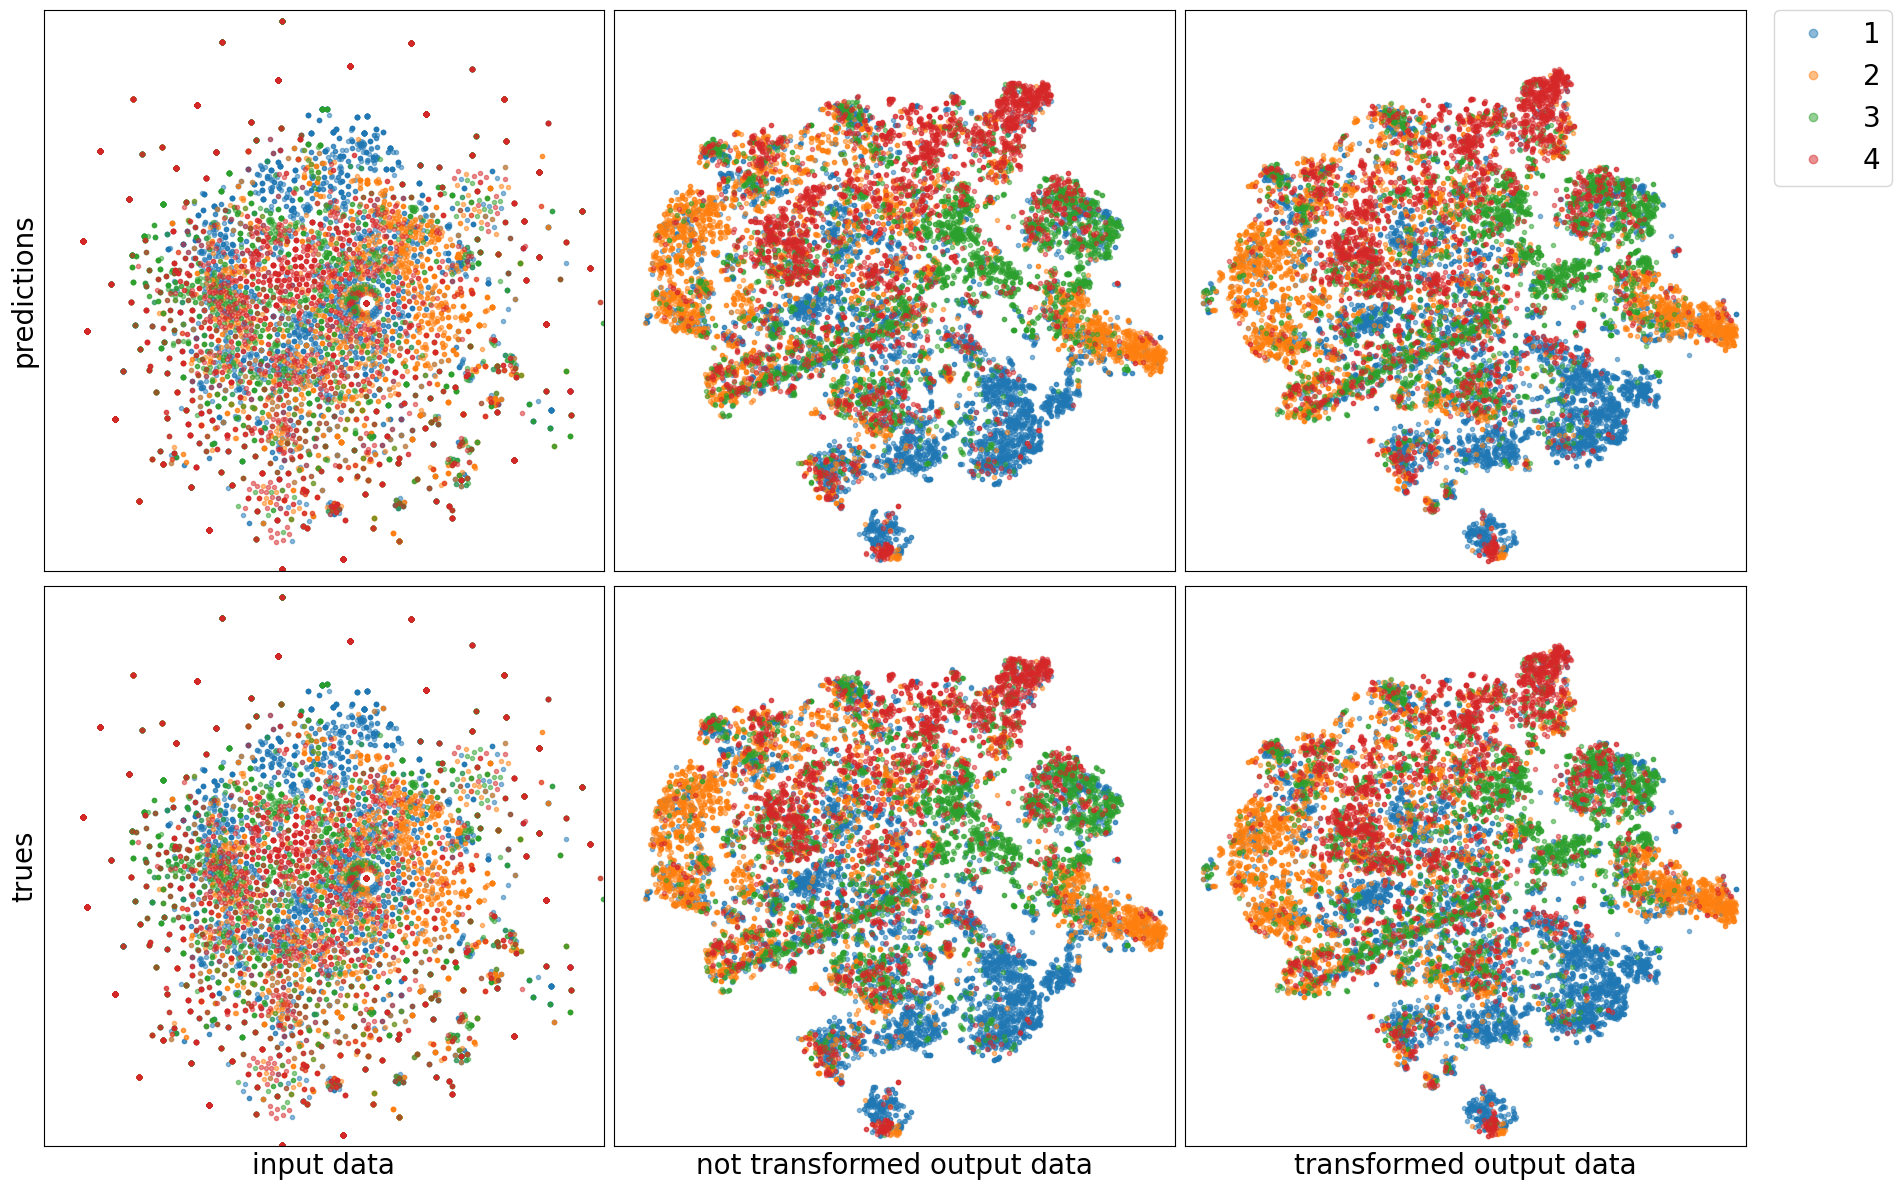

In [ ]:
draw_all_results_tsne('some title')

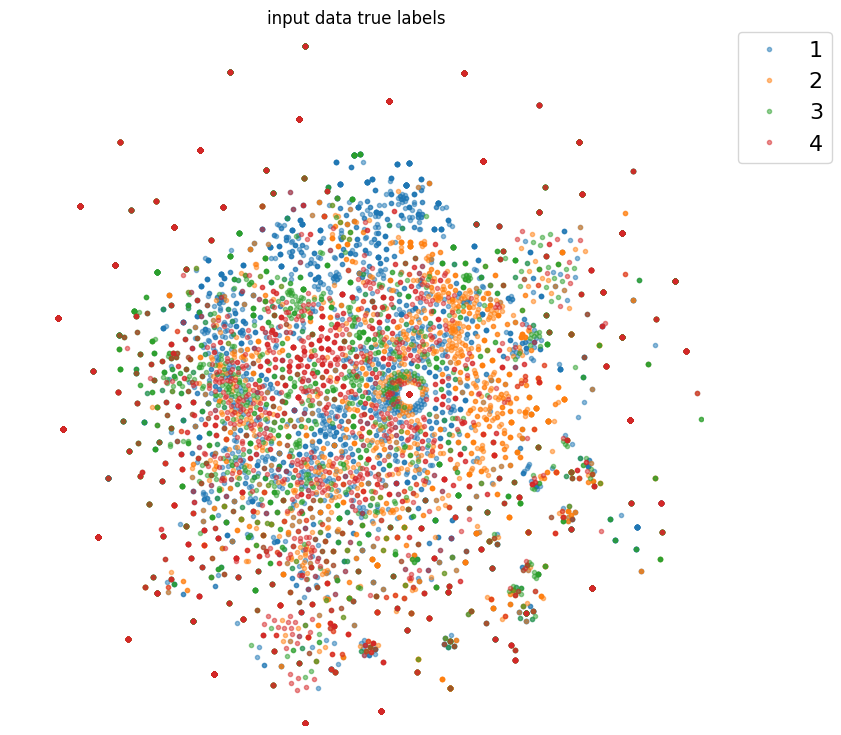

In [203]:
labels = torch.argmax(y_trues[x_batches.cpu().to(torch.long)], dim=1)
draw_result_tsne(labels, in_result, 'input data true labels')

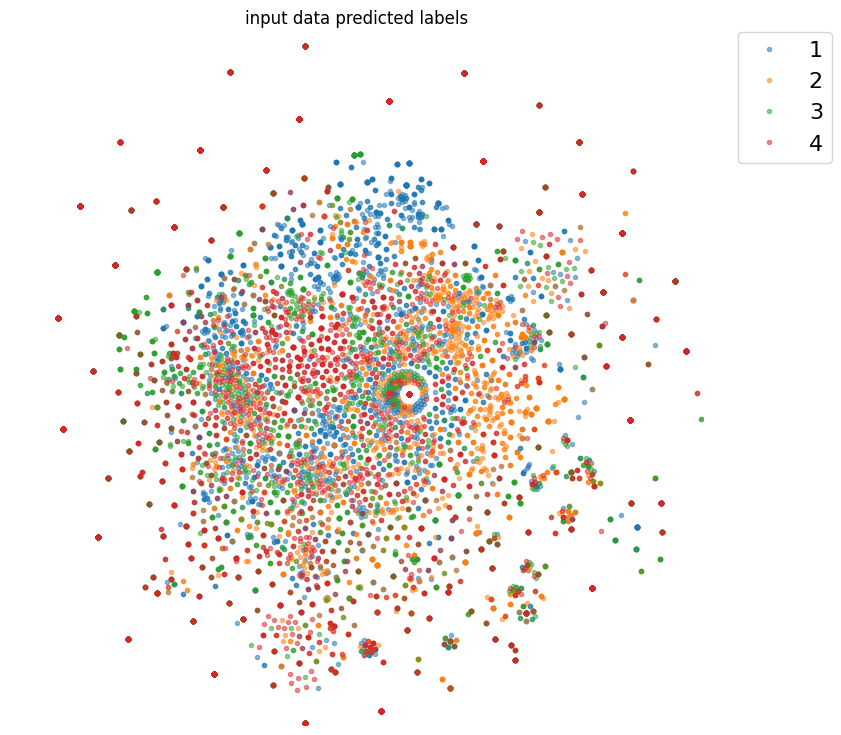

In [204]:
labels = torch.argmax(y_preds[x_batches.cpu().to(torch.long)], dim=1)
draw_result_tsne(labels, in_result, 'input data predicted labels')

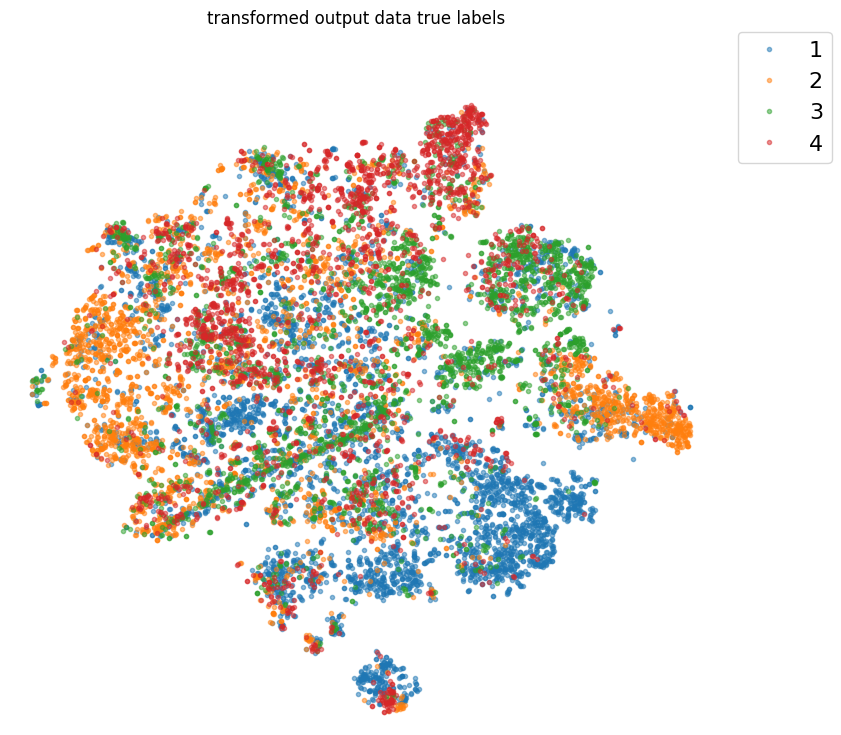

In [205]:
labels = torch.argmax(y_trues[x_batches.cpu().to(torch.long)], dim=1)
draw_result_tsne(labels, out_result, 'transformed output data true labels')

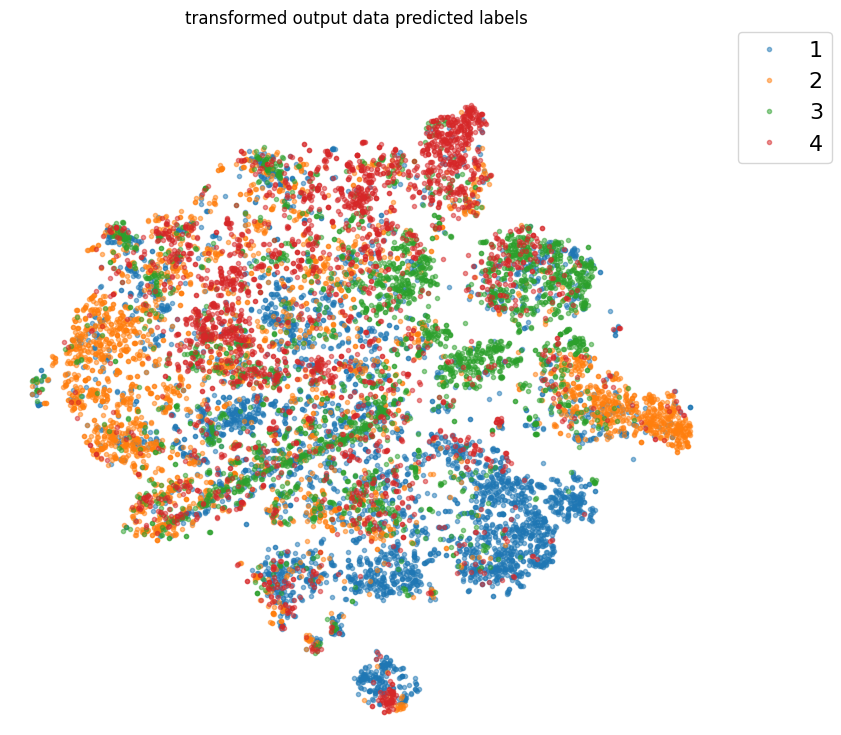

In [206]:
labels = torch.argmax(y_preds[x_batches.cpu().to(torch.long)], dim=1)
draw_result_tsne(labels, out_result, 'transformed output data predicted labels')

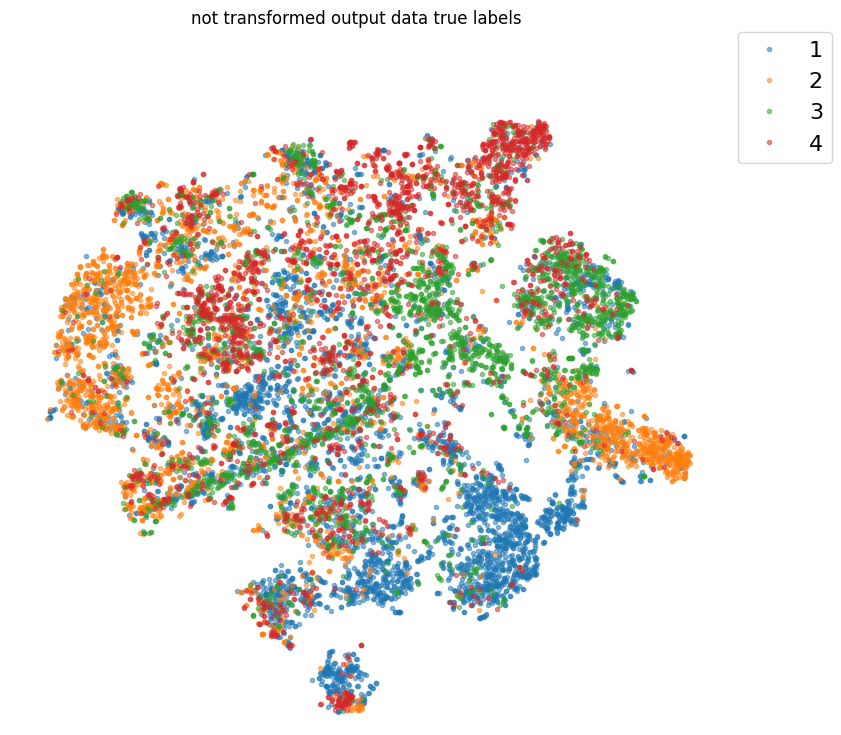

In [207]:
labels = torch.argmax(y_trues[x_batches.cpu().to(torch.long)], dim=1)
draw_result_tsne(labels, out2_result, 'not transformed output data true labels')

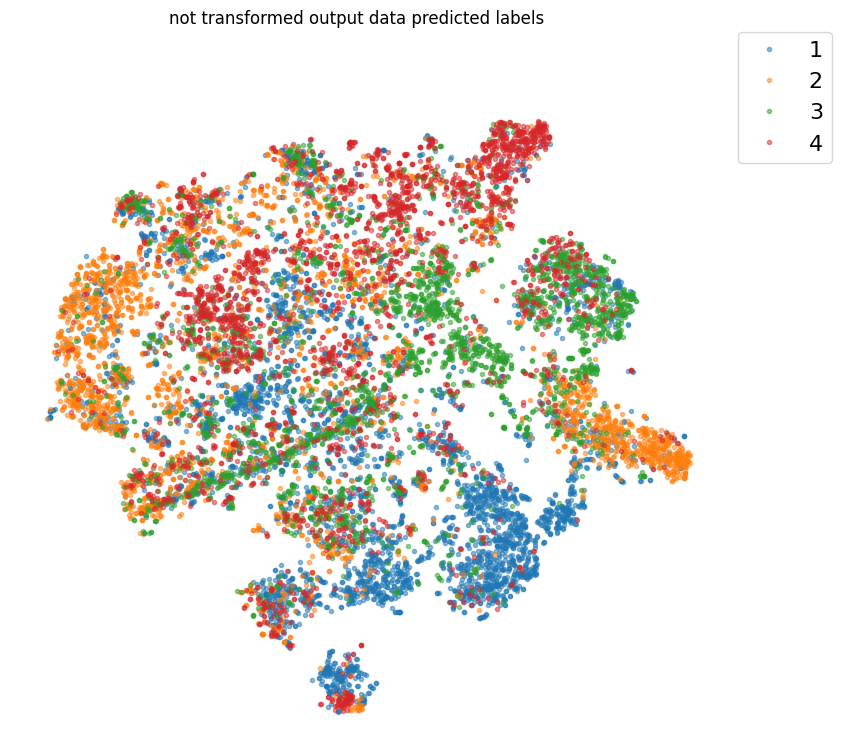

In [208]:
labels = torch.argmax(y_preds[x_batches.cpu().to(torch.long)], dim=1)
draw_result_tsne(labels, out2_result, 'not transformed output data predicted labels')

0
1
2
3


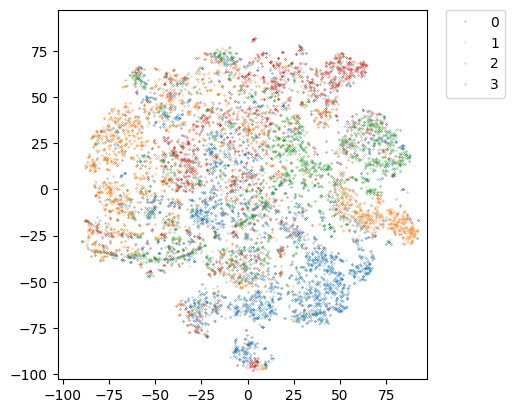

In [131]:
tsne_result_df = pd.DataFrame({'tsne_1': out2_result[:,0], 'tsne_2': out2_result[:,1], 'label': labels})

tsne_result_df = tsne_result_df.groupby('label')
for name, group in tsne_result_df:
    plt.plot(group['tsne_1'], group['tsne_2'], marker='o', linestyle='', markersize=0.2, label=name)
lim = (out2_result.min()-5, out2_result.max()+5)
plt.xlim(lim)
plt.ylim(lim)
plt.gca().set_aspect('equal')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not 'label'

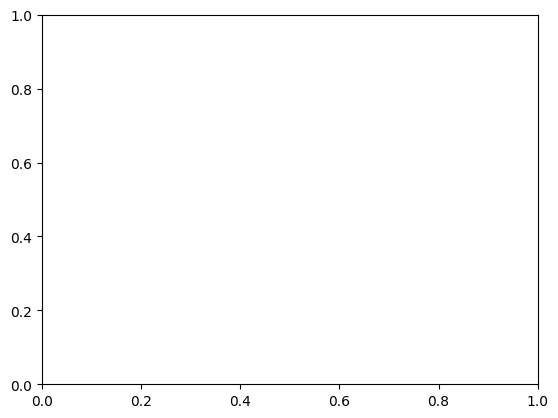

In [123]:
tsne_result_df = pd.DataFrame({'tsne_1': out2_result[:,0], 'tsne_2': out2_result[:,1], 'label': labels})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax, s=5)
lim = (out2_result.min()-5, out2_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

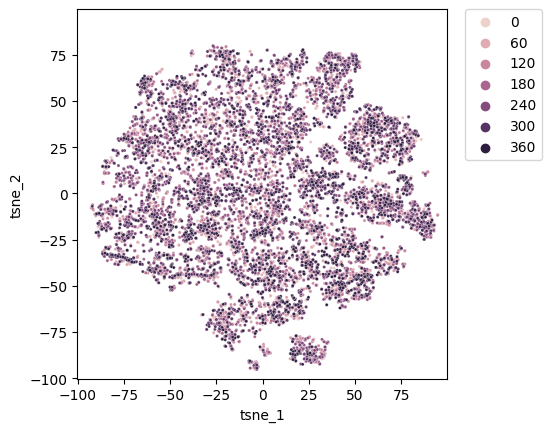

In [83]:
tsne_result_df = pd.DataFrame({'tsne_1': out_result[:,0], 'tsne_2': out_result[:,1], 'label': labels})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=5)
lim = (out_result.min()-5, out_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

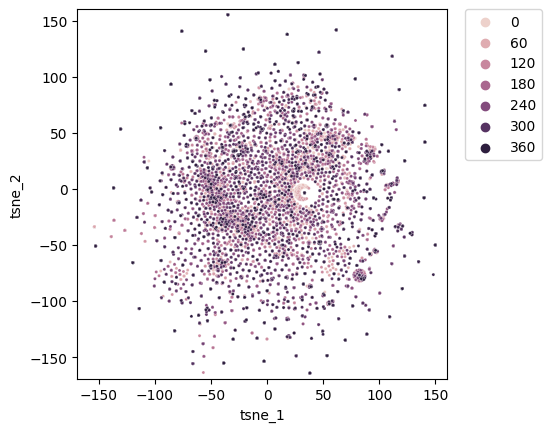

In [84]:
tsne_result_df = pd.DataFrame({'tsne_1': in_result[:,0], 'tsne_2': in_result[:,1], 'label': labels})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=5)
lim = (in_result.min()-5, in_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

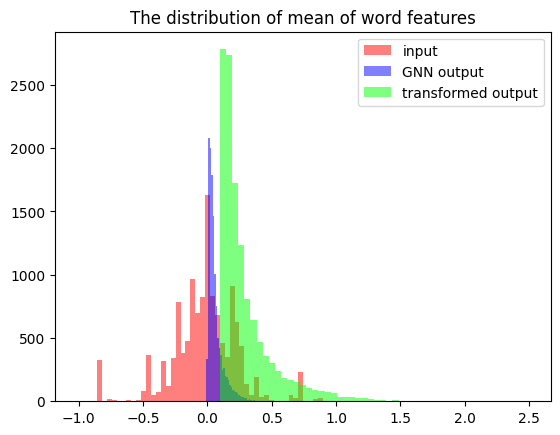

In [281]:
plt.hist(x_in.detach().cpu().mean(dim=1), bins=50, fc=(1, 0, 0, 0.5), label='input')
plt.hist(x_out2.detach().cpu().mean(dim=1), bins=50, fc=(0, 0, 1, 0.5), label='GNN output')
plt.hist(x_out.detach().cpu().mean(dim=1), bins=50, fc=(0, 1, 0, 0.5), label='transformed output')
plt.legend()
plt.title('The distribution of mean of word features')
plt.show()

In [62]:
x_out.mean(dim=1)

12593